[![Project Status: WIP – Initial development is in progress, but there has not yet been a stable, usable release suitable for the public.](https://www.repostatus.org/badges/latest/wip.svg)](https://www.repostatus.org/#wip)

# pythemap
Investigating schema-free encoding of categorical geodata using prime numbers

*Hint: this README was generated by a jupyter notebook and automatically exported into Markdown. You might want to open the README.ipynb file to see the original version.*

# Table of Contents
* [1   Description](#1-description)
* [2   Example](#2-example)
* [3   Use-cases](#3-use-cases)
* [4   Installation](#4-installation)
* [5   Acknowledgements, contact and how to cite](#5-acknowledgements-contact-and-how-to-cite)

## 1 Description

Prime numbers are routinely used in a variety of applications, e.g., cryptography and hashing. A prime number can only be divided by 1 and the number itself. A semi-prime number is a product of two or more prime numbers (e.g. 5*3=15) and can only be formed by these numbers (e.g. 3 and 5). Exploiting this mathematical property allows schema-free encoding of geographical data in nominal or ordinal measurement scales for thematic maps. Schema-free encoding becomes increasingly important in the context of data variety. In this paper, I investigate the encoding of categorical thematic map data using prime numbers instead of a sequence of all natural numbers (1,2,3,4 ... n) as the category identifier. When prime numbers are multiplied, the result as a single value contains the information of more than one location category. I demonstrate how this encoding can be used on three use-cases, (1) a hierarchical legend for one theme (CORINE land use / land cover), (2) a combination of multiple topics in one theme (Köppen-Geiger climate classification), and (3) spatially overlapping regions (tree species distribution). Other applications in the field of geocomputation in general can also benefit from schema-free approaches with dynamic instead of handcrafted encoding of geodata.

## 2 Example

The following example shows how to use the pythemap python package for encoding and decoding a dataset using prime numbers.

### 2.1 Preparation

Import pythemap as python package as follows:

In [1]:
from pythemap import geo

Suppose the following legend with three hierarchical layers will be used to reference the category identifiers in a dataset. The traditional approach would be to construct either a raster with three bands, three separate raster files, or use digit positions:

                     Vegetation                                          built-up
                      /     \                                         /     |     \
                     /       \                                       /      |      \
           agriculture        forest                       residential  industrial  commercial
              /               /    \
             /               /      \
    crop field         unmanaged  managed

The strutcture can be represented as JSON (Javascript Object Notation) as follows:

In [2]:
root =  {
        "metadata":{
            "type":"hierarchy"
        },
        "items": {
            "vegetation":{
                "agriculture":{
                    "crop field":{}
                },"forest":{
                    "managed":{},
                    "natural":{}
                }

            },
            "built-up":{
                "residential":{},
                "industrial":{},
                "commercial":{}
            }
    }
}

Consider the simple dataset with the spatial arrangement as follows. The three hierarchical layers are represented in three bands. Each of the three bands consist of four pixels.

![](./docs/res/example-layers.png)

As numpy array, it looks like this:

In [3]:
import numpy
data = numpy.array(
    [
        [
            ["vegetation", "agriculture", "crop field"],
            ["vegetation", "forest", "managed"]
        ],
        [
            ["vegetation", "agriculture", "crop field"],
            ["vegetation", "forest", "natural"]
        ],
    ])

Several steps are now important to encode the dataset using the hierarchy. At first, create a legend object and put the JSON in it. This step will **manipulate the legend by adding prime numbers**.

In [4]:
legend = geo.Legend()
legend.put(root)

Second, we need to create a raster object in which the operations encode/decode etc will be conducted.

In [5]:
r = geo.Raster()

### 2.2 Encoding

The raster object owns methods for encoding and decoding. In this case the raster (numpy data array) will be encoded using the legend, which was just generated.

In [6]:
encoded = r.encode(data, legend, keep = True)

The dataset is now compressed and encoded using semi-primes.

In [7]:
print(encoded)

[[105 429]
 [105 561]]


To comprehend what was going on, it is possible to look at the modified legend. The legend object took JSON and augmented it with unique identifiers for all categories. The main point here is that all identifiers are prime numbers:

In [8]:
import json
print(legend.exportLegend())

{'metadata': {'type': 'hierarchy'}, 'items': {'vegetation': {'child': {'agriculture': {'child': {'crop field': {'child': {}, 'prime': mpz(7)}}, 'prime': mpz(5)}, 'forest': {'child': {'managed': {'child': {}, 'prime': mpz(13)}, 'natural': {'child': {}, 'prime': mpz(17)}}, 'prime': mpz(11)}}, 'prime': mpz(3)}, 'built-up': {'child': {'residential': {'child': {}, 'prime': mpz(23)}, 'industrial': {'child': {}, 'prime': mpz(29)}, 'commercial': {'child': {}, 'prime': mpz(31)}}, 'prime': mpz(19)}}}


### 2.3 Creating masks

#### 2.3.1 Using a single selection criterion

The encoded categories can be used to generate masks. Although the categories are on a different levels in the hierarchy, the mask can be generated using the semi-prime number stored in the cells. Since the legend is provided together with the dataset, it is not necessary to know and manage the prime number. Instead, use the label from the legend - internally the name will be mapped to the corresponding identifier.

In [9]:
r.mask("forest", encoded, legend)

array([[0, 1],
       [0, 1]])

In [10]:
r.mask("crop field", encoded, legend)

array([[1, 0],
       [1, 0]])

In [11]:
r.mask("vegetation", encoded, legend)

array([[1, 1],
       [1, 1]])

#### 2.3.3 Using multiple selection criteria

It is also possible to pass more than one category for selection, e.g., as list. In this case, every occurrence of at least one of them will generate a true value. It therefore behaves like an OR logic:

In [12]:
r.mask(["crop field", "managed"], encoded, legend)

array([[1, 1],
       [1, 0]])

If there are several hits, e.g., in the case of a hierarchical legend, the values indicate the number of hits:

In [13]:
r.mask(["forest", "managed"], encoded, legend)

array([[0, 2],
       [0, 1]])

In the example above, every cell, which is either forest or managed will be listed. Sometimes (in larger examples) it is necessary to select them explicity with an AND logic. This can be represented like this:

In [14]:
r.mask(["forest", "managed"], encoded, legend, logic = "AND")

array([[0, 1],
       [0, 0]])

In this case, only cells which are managed forests will be considered.

### 2.4 Decoding

It is also possible to decode the encoded dataset back to a multi-layer approach (but who would want to do that?) .... 

In [15]:
r.decode(encoded)

array([[['vegetation', 'agriculture', 'crop field'],
        ['vegetation', 'forest', 'managed']],

       [['vegetation', 'agriculture', 'crop field'],
        ['vegetation', 'forest', 'natural']]], dtype=object)

### 2.5 Using stored objects

When the "keep" option is used during the encoding, the dataset is stored within the raster object and it is not necessary to provide it as argument in subsequent access as it was the case in the examples above. Providing an argument might be handy if you use the functions with a dataset, which is not stored in the python object (e.g. loaded from an external file), or which is extremely large and you might want to split it up in a parallelised process.

However, if the data is stored, the following expression yields the same result:

In [16]:
r.decode()

array([[['vegetation', 'agriculture', 'crop field'],
        ['vegetation', 'forest', 'managed']],

       [['vegetation', 'agriculture', 'crop field'],
        ['vegetation', 'forest', 'natural']]], dtype=object)

The same will work for the mask() functions as well:

In [17]:
r.mask("forest")

array([[0, 1],
       [0, 1]])

*Hint: If you provide data (or another legend) as argument, it will be used even if something else is already stored.*

### 2.6 Adding and removing layers

Suppose, the dataset is missing the third layer, which need to be added later. Initially, the dataset looks as follows:

In [18]:
data = numpy.array(
    [
        [
            ["vegetation", "agriculture"],
            ["vegetation", "forest"]
        ],
        [
            ["vegetation", "agriculture"],
            ["vegetation", "forest"]
        ],
    ])

And this is the layer, which will be added:

In [19]:
new_layer = numpy.array(
    [
        [
            "crop field",
            "managed"
        ],
        [
            "crop field",
            "natural"
        ],
    ])

The add function of the raster object can be used to accomplish this:

In [20]:
combined = r.add(layer = new_layer, data = r.encode(data,legend), legend = legend)
print(combined)

[[105 429]
 [105 561]]


You can see that from the semi-prime numbers as cell values, the enoded dataset is the same as in the previous example where the three layers were encoded all at once in the beginning. All of the masks work as well:

In [21]:
r.mask("crop field", combined, legend)

array([[1, 0],
       [1, 0]])

Similarly, it is possible to remove a layer:

In [22]:
removed = r.remove(layer = new_layer, data = combined, legend = legend)
print(removed)

[[15 33]
 [15 33]]


With this dataset, the calculation of the mask will yield an empty mask without true values

In [23]:
r.mask("crop field", removed, legend)

array([[0, 0],
       [0, 0]])

The result may be forwarded to the decode function to convert into the classes:

In [24]:
r.decode(
    r.remove(layer = new_layer, data = combined, legend = legend))

array([[['vegetation', 'agriculture', None],
        ['vegetation', 'forest', None]],

       [['vegetation', 'agriculture', None],
        ['vegetation', 'forest', None]]], dtype=object)

With defaults settings, the whole layer is used. To select only specific areas, it is possible to apply a mask for which the operation should be performed. See the following step-by-step explaination.
Suppose this is the original data, to which the new layer should be added:

In [25]:
encoded_mask_example = r.encode(data, legend)
print(encoded_mask_example)

[[15 33]
 [15 33]]


This is the layer, which will be added

In [26]:
print(new_layer)

[['crop field' 'managed']
 ['crop field' 'natural']]


... but limited to the first row. Everything with 0 will be considered False (not in target area) and everything != 0 will be considered True (in target area):

In [27]:
mask = numpy.array([
    [1, 2],
    [0, 0]
])

If the mask applied, only these areas are considered:

In [28]:
r.add(layer = new_layer, data = encoded_mask_example, legend = legend, mask=mask)

array([[105, 429],
       [ 15,  33]])

In contrast, without a mask:

In [29]:
r.add(layer = new_layer, data = encoded_mask_example, legend = legend)

array([[105, 429],
       [105, 561]])

### 2.5 Import and export

It is also possible to import and export data, which are stored in the array. For example, the encoded dataset from the previous example can be imported into a new raster object and exported as well:


In [30]:
io_example = geo.Raster()

#
# Import the already encoded dataset
#
io_example.importEncoded(encoded)

#
# Export the dataset, which is stored in the io_example object
#
io_example.exportEncoded()

array([[105, 429],
       [105, 561]])

## 3 Use-cases

### 3.1 Hierarchical legends of one theme

CORINE is a pan-european layer for land use and land cover classes with three hierarchies. Here, only Austria is considered.

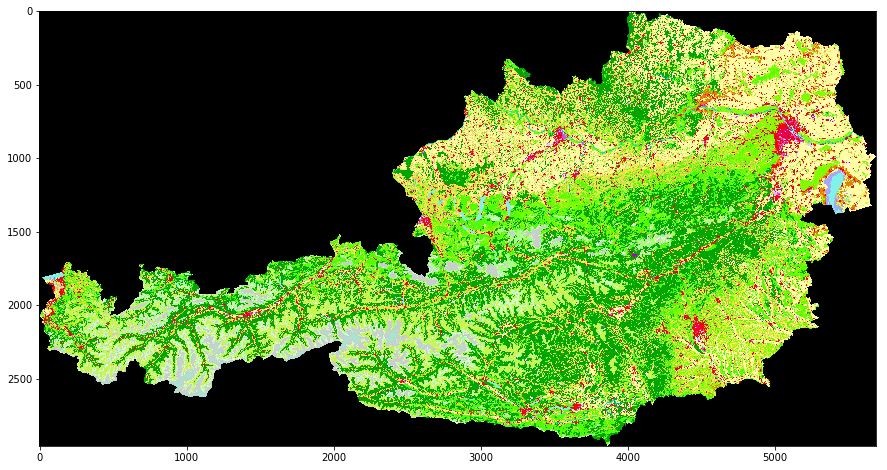

In [2]:
image = mpimg.imread("../../data/CORINE/austria_corine_rgb.jpg")
plt.figure(figsize=(15,10))
plt.imshow(image)
plt.show()

Data import and preparation

In [3]:
#
# Import numpy and pythemap geo functions
#
import numpy
from pythemap import geo

#
# Generate a new raster layer
#
r = geo.Raster()

#
# Generate a new legend. In pythemap, the data is not necessarily
# human-readable and the legend is required to be able to extract the 
# values.
#
legend = geo.Legend()

#
# This is how the plain legend originally looks like. The legend type is 
# "hierarchy".
#
root =  {
        "metadata":{
            "type":"hierarchy"
        },
        "items": {
            "Artificial surfaces":{
                "Urban fabric":{
                    "Continuous urban fabric":{},
                    "Discontinuous urban fabric ":{}
                },
                "Industrial, commercial and transport units":{
                    "Industrial or commercial units ":{},
                    "Road and rail networks and associated land":{},
                    "Port areas":{},
                    "Airports":{}
                },
                "Mine, dump and construction sites":{
                    "Dump sites":{},
                    "Construction sites":{},
                    "Mineral extraction sites":{}
                },
                "Artificial, non-agricultural vegetated areas":{
                    "Green urban areas":{},
                    "Sport and leisure facilities":{}
                }
            },
            "Argicultural areas":{
                "Arable land":{
                    "Non-irrigated arable land":{},
                    "Permanently irrigated land":{},
                    "Rice fields":{},
                },
                "Permanent crops":{
                    "Vineyard":{},
                    "Fruit trees and berry plantations":{},
                    "Olive groves":{},
                },
                "Pastures":{
                    "Pastures":{}
                },
                "Heterogeneous agricultural areas":{
                    "Annual crops associated with permanent crops":{},
                    "Complex cultivation patterns ":{},
                    "Land principally occupied by agriculture, with significant areas of natural vegetation":{},
                    "Agro-forestry areas":{},
                }
            },
            "Forest and semi-natural areas":{
                "Forests":{
                    "Broad-leaved forest":{},
                    "Coniferous forest":{},
                    "Mixed forest":{},
                },
                "Scrub and/or herbaceous vegetation associations":{
                    "Natural grasslands":{},
                    "Moors and heathland":{},
                    "Sclerophyllous vegetation":{},
                    "Transitional woodland-shrub":{},
                },
                "Open spaces with little or no vegetation":{
                    "Beaches, dunes, sands":{},
                    "Bare rocks":{},
                    "Sparsely vegetated areas":{},
                    "Burnt areas":{},
                    "Glaciers and perpetual snow":{},
                },
            },
            "Wetlands":{
                "Inland wetlands":{
                    "Inland marshes":{},
                    "Peat bogs":{},
                },
                "Maritime wetlands":{
                    "Salt marshes":{},
                    "Salines":{},
                    "Intertidal flats":{},
                },
            },
            "Water bodies":{
                "Inland waters":{
                    "Water courses":{},
                    "Water bodies":{},
                },
                "Marine waters":{
                    "Coastal lagoons":{},
                    "Estuaries":{},
                    "Sea and ocean":{},
                },
            }
        }
    }

#
# Add the json to the layer class. It will be remembered and used in future
# to encode/decode/mask the data
#
legend.put(root)

#
# The non-encoded CORINE land use / land cover was pre-processed
# and can be imported here as numpy array.
#
a = numpy.load("../data/CORINE/austria_nd.npy")

With the "encode" function the three hierarchies of the CORINE dataset can be encoded and compressed into one layer

In [4]:
encoded = r.encode(a, legend, False)

In [5]:
#
# Remove the original array as it takes too much space and is not necessary any more
#
a = None

Once the data is encoded, it is possible create masks based on selections of using legend entries

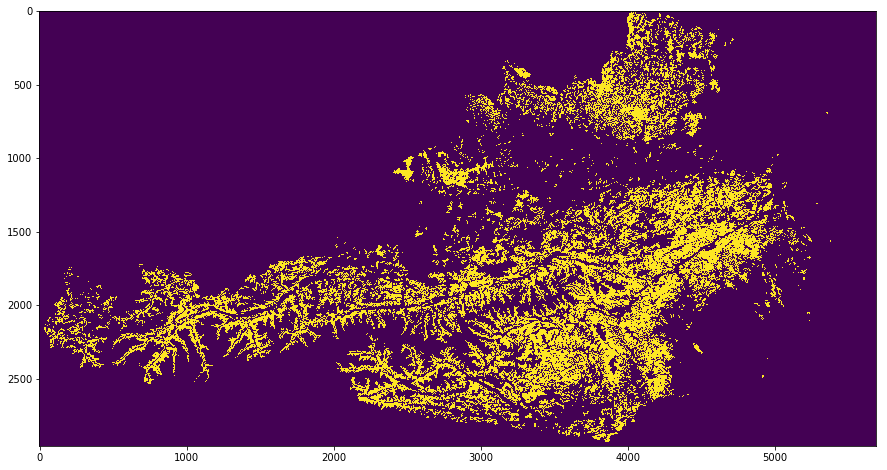

In [6]:
mask = r.mask("Coniferous forest", encoded, legend)
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

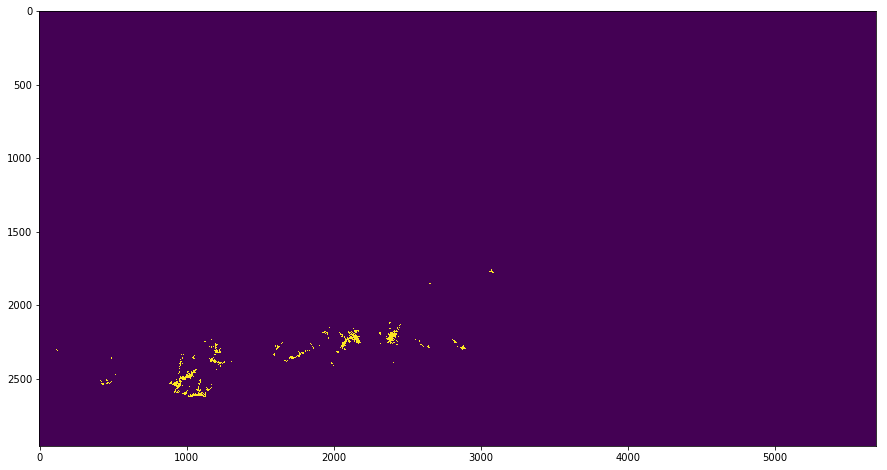

In [16]:
mask = r.mask("Glaciers and perpetual snow", encoded, legend)
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

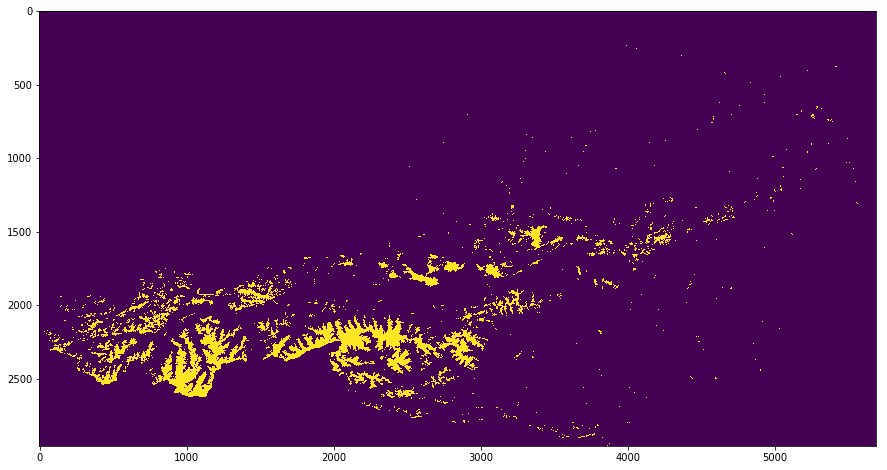

In [24]:
mask = r.mask(["Open spaces with little or no vegetation","Mineral extraction sites"], encoded, legend)
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

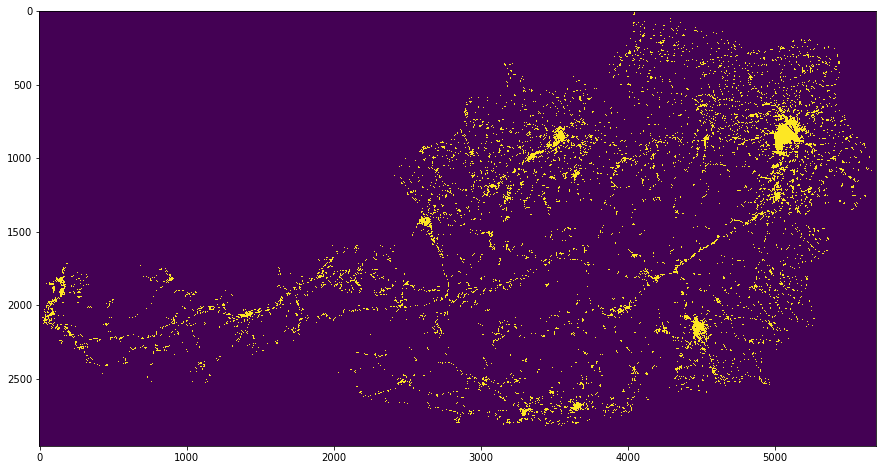

In [17]:
mask = r.mask("Artificial surfaces", encoded, legend)
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

At this point the maximum value in the encoded dataset is ..

In [26]:
numpy.max(encoded)

21093827

... which allows to store it using 32-bit integer data type.

### 3.2 Multiple categorical layers with different sub-themes

The Köppen-Geiger climate classes are constructed using three main characteristics based on "Main climates", "Precipitation" and "Temperature. See the map below.

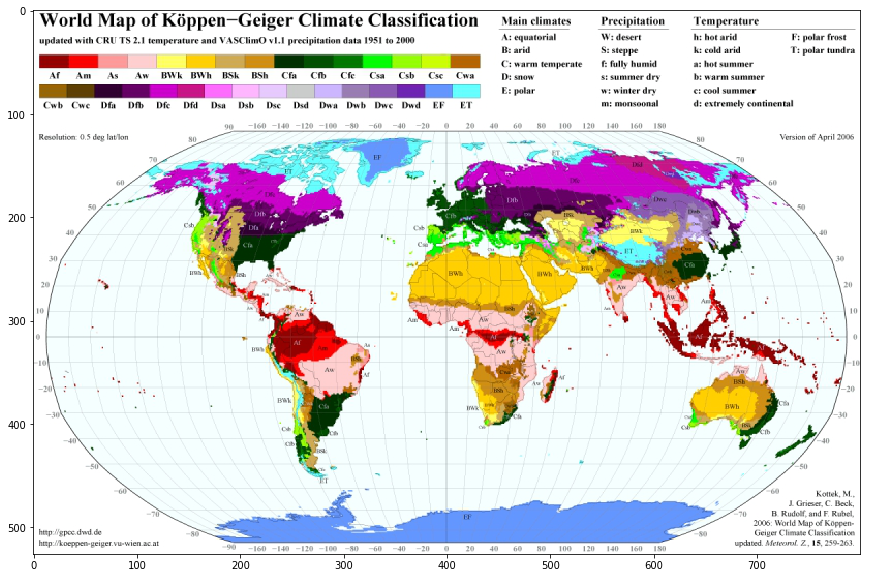

In [3]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread("../../data/ClimateZones/Kottel/Koeppen-Geiger-Overview.jpg")
plt.figure(figsize=(15,10))
plt.imshow(image)
plt.show()

Prepare and import the pre-processed data

In [5]:
#
# Import numpy and pythemap geo functions
#
import numpy
from pythemap import geo

#
# Generate a new raster layer
#
r = geo.Raster()

#
# Generate a new legend. In pythemap, the data is not necessarily
# human-readable and the legend is required to be able to traverse
# to the datums and extract the values.
#
legend = geo.Legend()

#
# This is how the plain legend originally looks like. The legend type is 
# "layers".
#
root =  {
        "metadata":{
            "type":"layers"
        },
        "items": {
            "climate":{
                "A":{},
                "B":{},
                "C":{},
                "D":{},
                "E":{}
            },
            "precipitation":{
                "W":{},
                "S":{},
                "f":{},
                "s":{},
                "w":{},
                "m":{},
            },
            "temperature":{
                "h":{},
                "k":{},
                "a":{},
                "b":{},
                "c":{},
                "d":{},
                "F":{},
                "T":{},
            }
        }
    }

#
# Add the json to the layer class. It will be remembered and used in future
# to encode/decode/mask the data
#
legend.put(root)

#
# The non-encoded Köppen-Geiger climate classification data was pre-processed
# and can be imported here as numpy array.
#
a = numpy.load("../../data/ClimateZones/ClimateZones_nd.npy")

With the encode method, the layers can be encoded and compressed into a single layer

In [6]:
encoded = r.encode(a, legend, False)

Based on the encoded layer it is possible to select the individual masks. For example, to extract polar climates it is possible to query the data using the capital letter "E", which represents polar climates in the Köppen-Geiger climate classification system. 

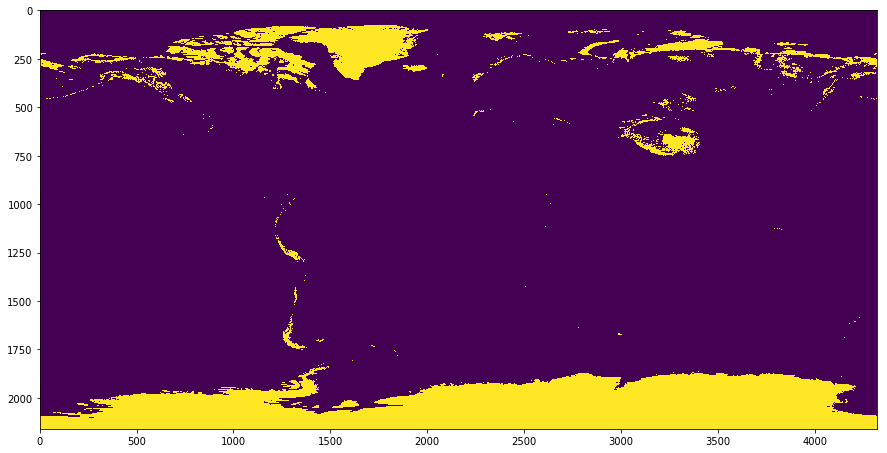

In [33]:
mask = r.mask("E", encoded, legend)
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

It is also possible to extract all areas which are either desert (capital letter "W") or steppe (capital letter "S).

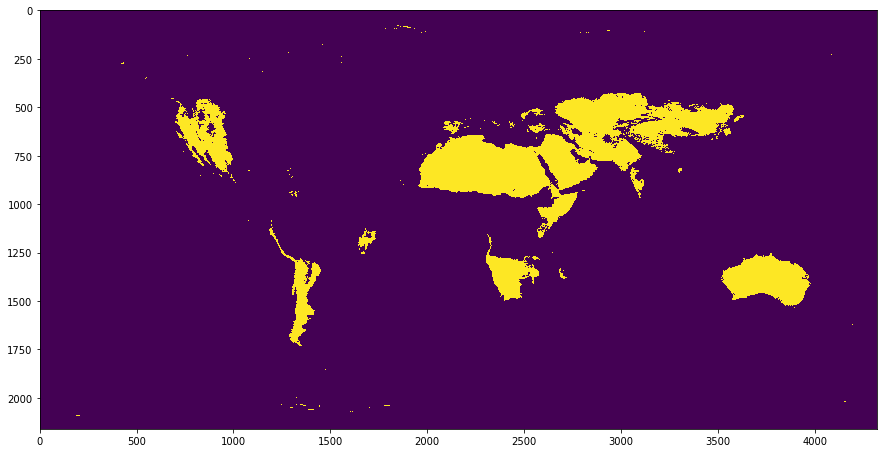

In [29]:
mask = r.mask(["W","S"], encoded, legend)
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

Multiple categories can be queries by using an array. The default logic is "OR".

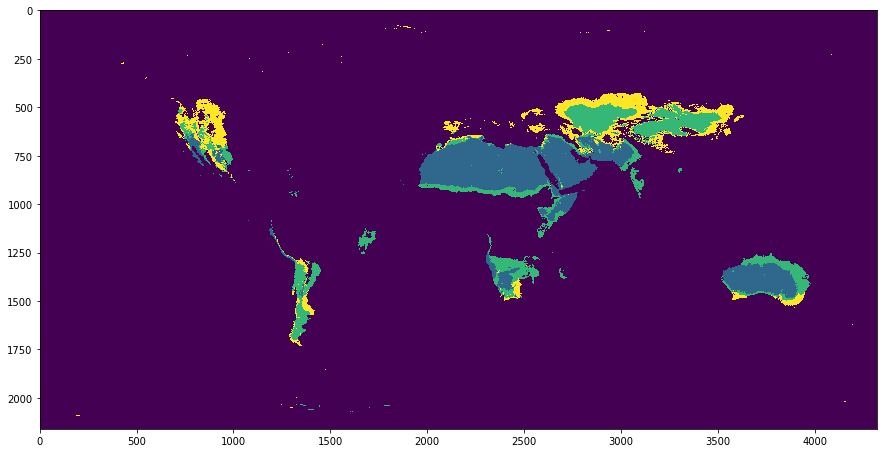

In [9]:
mask = r.mask(["B","S","k"], encoded, legend)
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

However, it is possible to explicitly use an "AND"-logic. In this example it is used to query the BWh climate.

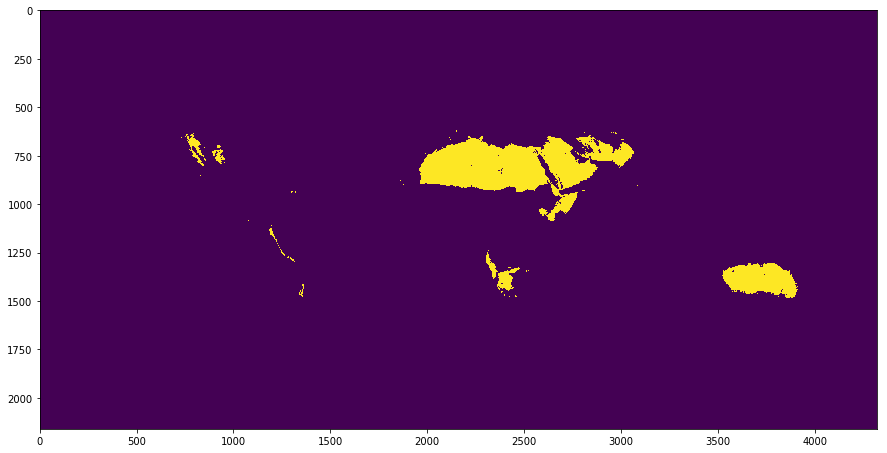

In [31]:
mask = r.mask(["B","W","h"], encoded, legend, logic = "AND")
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

At this point the maximum value in the encoded dataset is ...

In [11]:
numpy.max(encoded)

38909

... which allows to store the data in 16-bit integer.

### 3.3 Overlapping spatial distributions of one theme

An example for overlapping regions are species distributions such as the tree species here.

In [27]:
#
# Import numpy and pythemap geo functions
#
import numpy
from pythemap import geo

#
# Generate a new raster layer
#
r = geo.Raster()

#
# Generate a new legend. In pythemap, the data is not necessarily
# human-readable and the legend is required to be able to extract the 
# values.
#
legend = geo.Legend()

#
# This is how the plain legend originally looks like. The legend type is 
# "options".
#
root =  {
        "metadata":{
            "type":"options"
        },
        "items": {
            "Betula pendula": ["Silver birch"],
            "Fagus sylvatica": ["European beech"],
            "Pinus pinaster": ["Maritime pine", "Pine"],
            "Quercus robur": ["English oak", "Oak"]
            }
        }

#
# Add the json to the layer class. It will be remembered and used in future
# to encode/decode/mask the data
#
legend.put(root)

#
# The non-encoded CORINE land use / land cover was pre-processed
# and can be imported here as numpy array.
#
a = numpy.load("../../data/TreeSpecies/tree_species_nd.npy")

Encode the dataset using the legend

In [28]:
encoded = r.encode(a, legend, False)

The mask can be generated from the encoded dataset

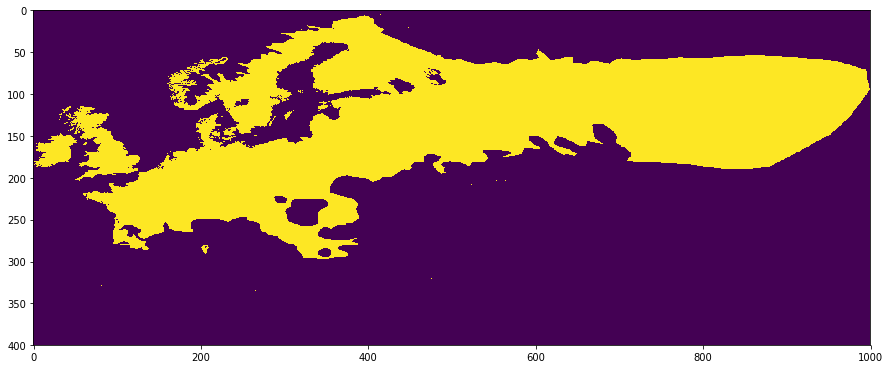

In [4]:
mask = r.mask("Betula pendula", encoded, legend)
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

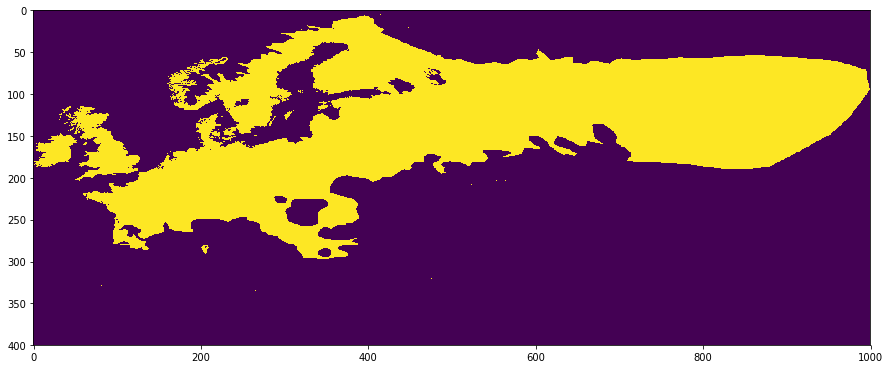

In [18]:
#
# Note that this is just the same data, but accessed using a different name.
# Therefore, the output should be the same
#
mask = r.mask("Silver birch", encoded, legend)
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

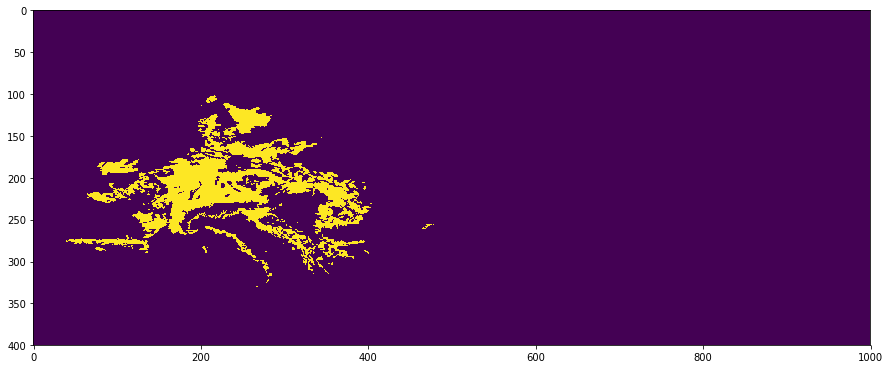

In [20]:
mask = r.mask("Fagus sylvatica", encoded, legend)
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

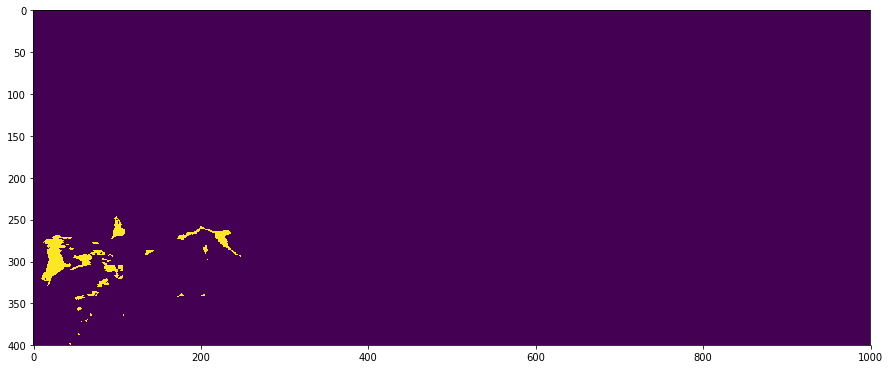

In [23]:
mask = r.mask("Maritime pine", encoded, legend)
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

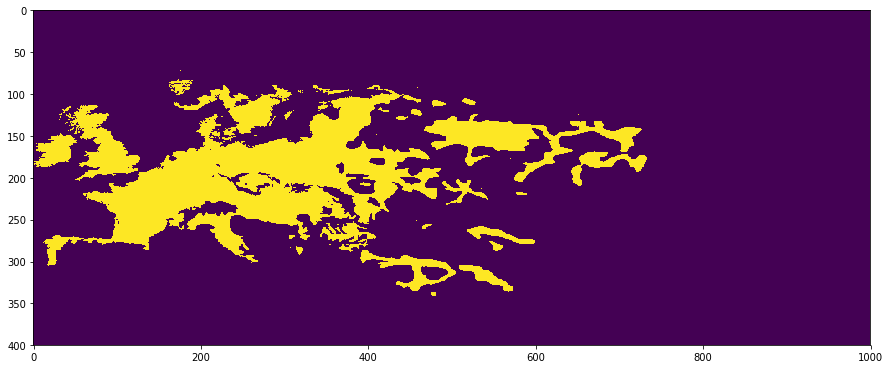

In [25]:
mask = r.mask("Oak", encoded, legend)
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

It is also possible to query all of them. Per default, it works like an "OR" operator, i.e., the map shows the number of occurrences. There are only three colours, because there is no area where all four tree species occur.

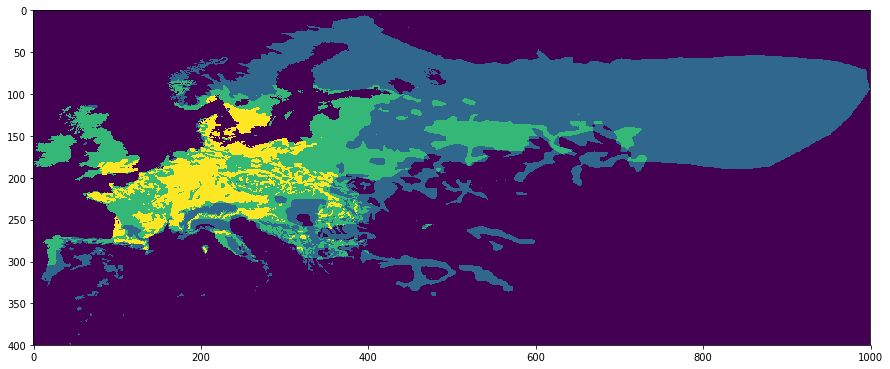

In [9]:
mask = r.mask(["Betula pendula","Fagus sylvatica","Pinus pinaster", "Quercus robur"], encoded, legend)
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

This is an example, which works like an "AND" operator, i.e, it shows all regions where both trees are occurring.

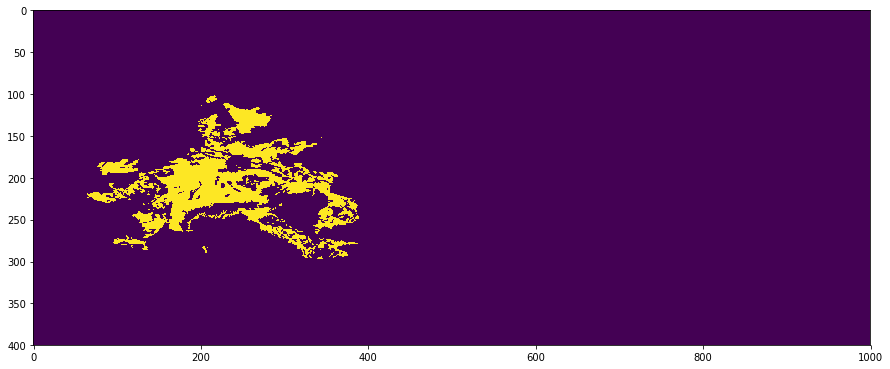

In [10]:
mask = r.mask(["Betula pendula","Fagus sylvatica"], encoded, legend, logic = 'AND')
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

It is possibly to add a new layer dynamically, here a silver fir

In [30]:
toadd = numpy.load("../../data/TreeSpecies/tree_species_toadd.npy")

#
# Do not forget to add the legend entry
#
combined = r.add(layer = toadd, data = encoded, legend = legend.addItem(item = {"Abies alba": ["Silver fir"]}))

The other tree species can be extracted without change in the selection operation ...

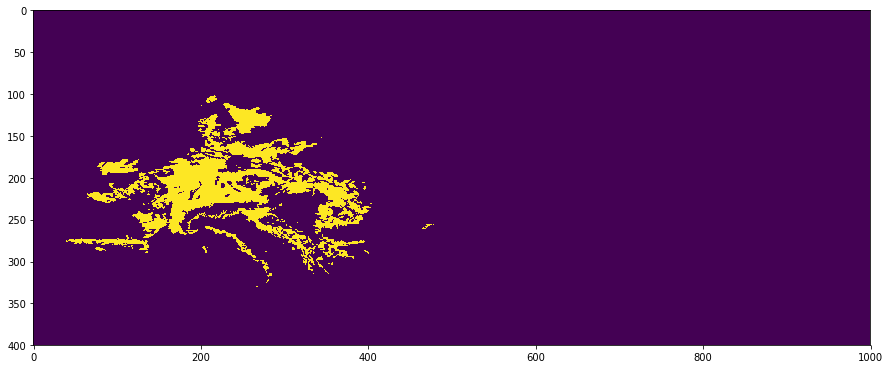

In [12]:
mask = r.mask("Fagus sylvatica", combined, legend)
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

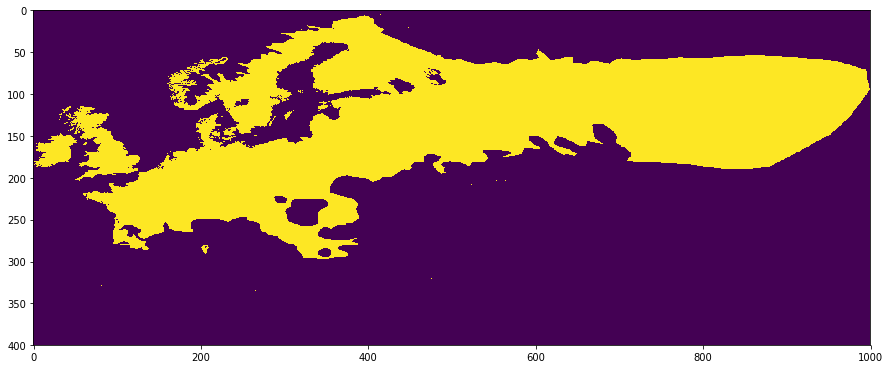

In [13]:
mask = r.mask("Betula pendula", combined, legend)
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

... as well as the new one

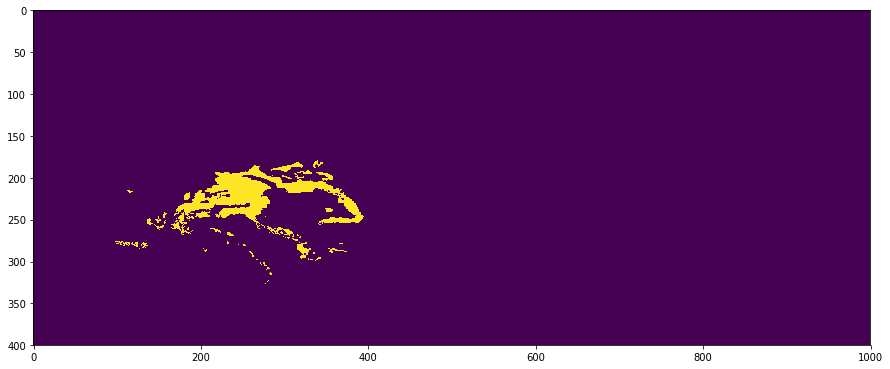

In [32]:
mask = r.mask("Abies alba", combined, legend)
plt.figure(figsize=(15,10))
plt.imshow(mask)
plt.show()

At this point the maximum value in the encoded dataset is ...

In [15]:
numpy.max(encoded)

385

... which allows to store the data in 12-bit or 16-bit integer.

## 4 Installation

pythemap can be installed as python package using

```bash
python setup.py install
```

## 5 Acknowledgements, contact and how to cite

This work was supported by the Austrian Science Fund (FWF) through the Doctoral College GIScience at the University of Salzburg (DK W1237-N23).

Contact point for any questions is:

```
Mr. Martin Sudmanns
PhD researcher
martin.sudmanns@sbg.ac.at
Interfaculty Department of Geoinformatics - Z_GIS, Integrated Spatial Analysis
Paris Lodron Univeristy of Salzburg
Schillerstraße 30, 5020 Salzburg, Austria
```